Load Model and Tokenizer

In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "cpu"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_17115/4006151839.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 12.95M


In [4]:
# tok.special2idx
tok.vocab_size # why so big bro ?? it should be extremely small ~ 92 ...


6068

Initialize MagiCab class instance 

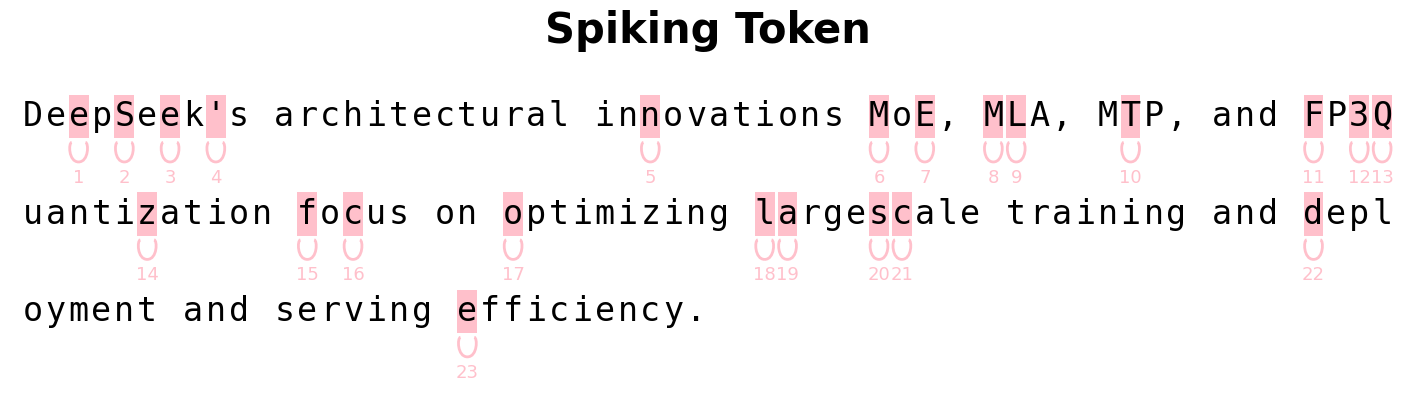

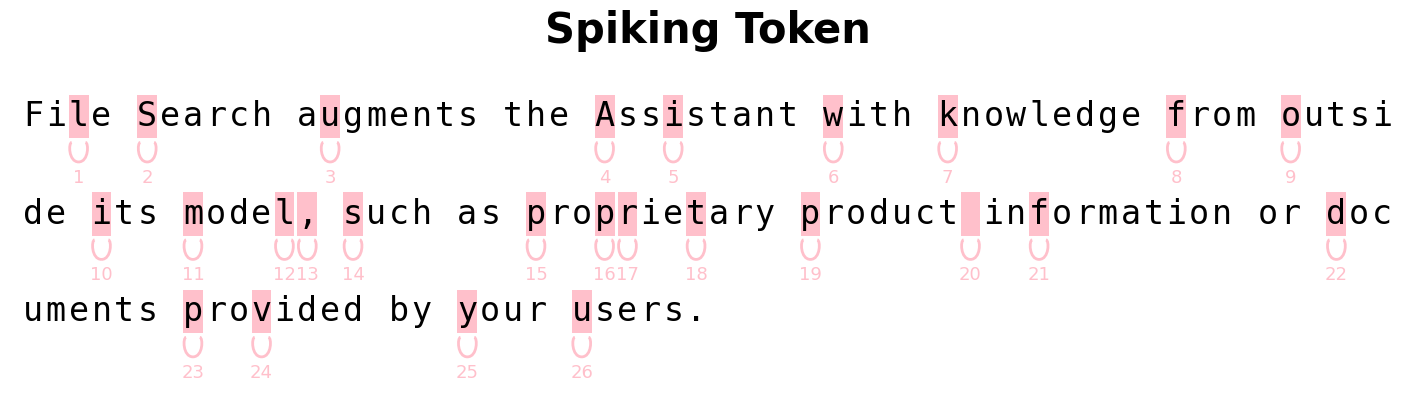

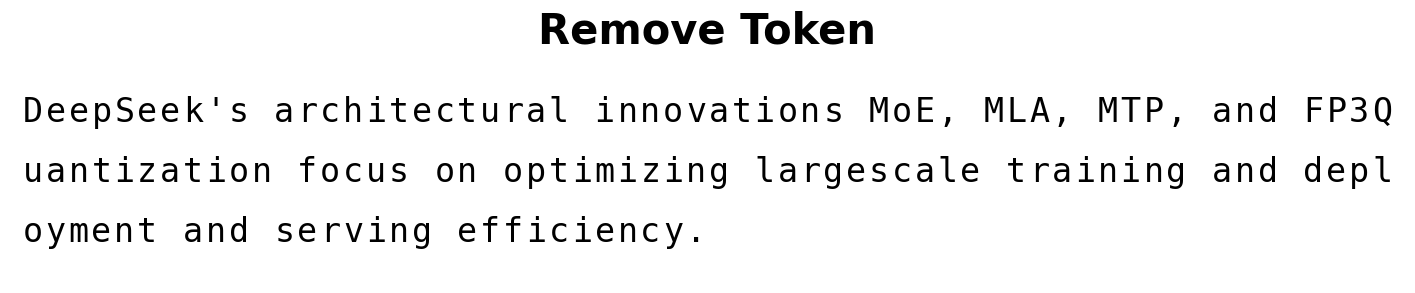

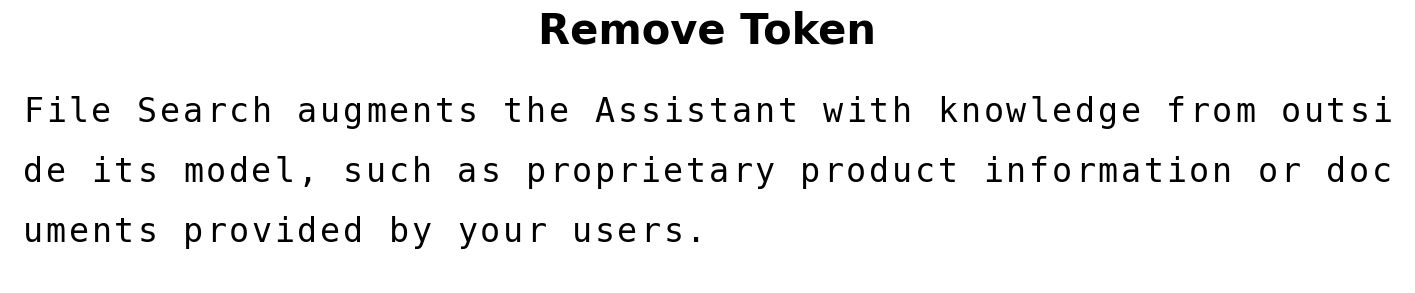

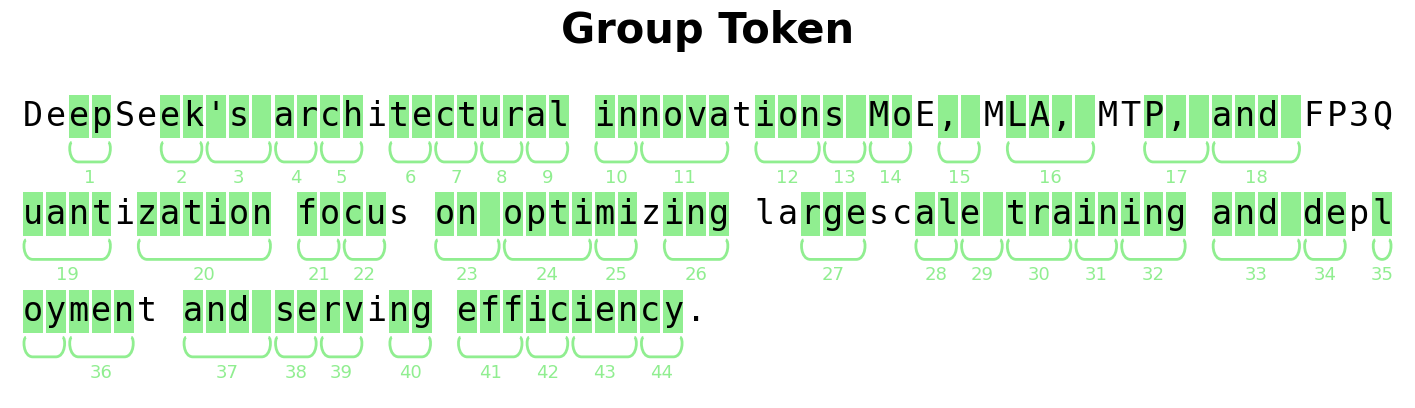

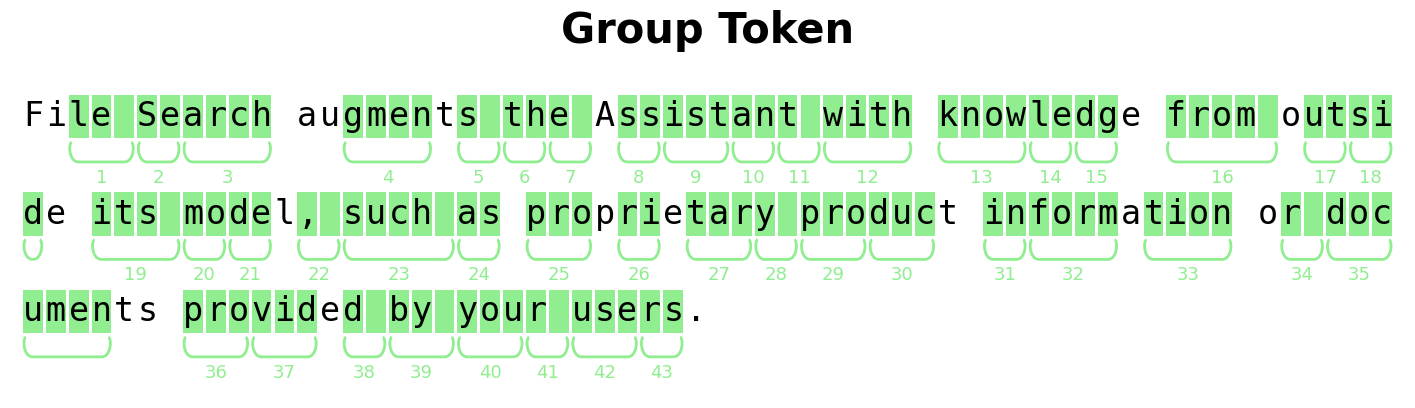

In [2]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base")

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts)

In [4]:
# (b). Batch Update
model, tokenizer = magicab.update_vocabulary(texts)

# Issue :: Updated tokenizer shrinks token length, causing mismatch length for batch texts 
#        - add padding token, but trained checkpoint does not have pad_token embedding in wte 
#        - need to update model config and re-train checkpoint 
#        - model's vocab_size is initialized from data's meta.pkl - it's about using ETokenizer to prepare data (update meta files)
#        - we also need to include files in meta so that we could load Etokenizer from and save Etokenizer to it. 

AssertionError: All token ids must be of the same length, or we need to pad them

In [7]:
from magicab.utils import inference 
from torch.nn import functional as F 

model, tokenizer = magicab.model, magicab.tokenizer
 
token_ids_list = [torch.tensor(tokenizer.encode(t), dtype=torch.long) for t in texts]

max_token_len = max([token_ids.shape[0] for token_ids in token_ids_list])

pad_token_id = tokenizer.special2idx["<pad>"]
token_ids_list = [F.pad(token_ids, pad=(max_token_len - token_ids.shape[0], 0), mode='constant', value=pad_token_id) for token_ids in token_ids_list]
            
token_ids = torch.stack(token_ids_list, dim=0)

input_ids = token_ids[:, :-1]
target_ids = token_ids[:, 1:]

# inference(magicab.model, magicab.tokenizer, text=texts, pad=True)

In [9]:
input_ids

tensor([[6067, 6067, 6067, 6067, 6067, 6067, 6067, 6067, 6067, 6067,   38,   71,
         6068,   53,   71,   71,   77, 6070, 6147, 6071,   75, 6072, 6073, 6074,
         6075,    2, 6076, 6080,   75, 6081, 6082,   47,   81,   39, 6083,   47,
           46,   35, 6083,   47,   54,   50, 6083, 6088,   40,   50,   21,   51,
           87, 6086, 6099, 6092, 6098, 6095, 6096, 6082, 6098,   81,   82, 6099,
         6100,   92, 6101,    2, 6102, 6104,   85,   69, 6075, 6125,   86, 6105,
         6076, 6101,    2, 6088,   70, 6068, 6108, 6109, 6089,    2, 6088, 6165,
         6111, 6101,    2,   71, 6113, 6117, 6118],
        [  40,   75,   78, 6125,   53,   71, 6147, 6071,    2,   67,   87,   73,
         6109, 6089, 6082,   86,   74, 6125,   35, 6126, 6128, 6086, 6129,   89,
         6131,    2,   77, 6077,   89, 6132, 6133, 6125,   72, 6136,   81, 6137,
         6138, 6106,    2, 6130, 6082,   79,   81, 6106,   78, 6083,   85,   87,
         6071,    2,   67, 6082,   82, 6134,   82, 6146, 

In [10]:
tokenizer.encode("<pad>")

[6067]

In [3]:
# (c). Work with training data batch

# magicab need to work with 'batch data'
import numpy as np 
dataset = 'enwiki'
block_size = 256 
batch_size = 4
device_type = 'cpu'

data_dir = os.path.join('data', dataset)

def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


x, y = get_batch('train')
# x - input ids | y - target ids 

# Magicab vocabulary update with batched tensor 
x.shape


torch.Size([4, 256])

In [5]:
# Update model -> save to checkpoint --> resume training 
# Update tokenizer -> prepare another 'data.bin' --> resume training 

In [4]:
# Update train/val/test.bin file using tokenizer 
from data.enwiki.util import prepare_enwiki_data

prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 

Input file path:  data/enwiki/enwik8_clean.txt
Total tokens: 54482072
train has 50,000,000 tokens
val has 2,000,000 tokens
test has 2,482,072 tokens


{'vocab_size': 90, 'tokenizer': <src.etoken.ETokenizer at 0x157fd17d0>}

In [ ]:
# Prepare Data request: 
# 'vocab_size' in meta.pkl 
